# Assigment3

In [217]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd

## Part1: Theoretical Problem

#### 3. (10 marks) Experimentally find the value of σ that maximizes the magnitude of the response for a black square of size 100×100 pixels on a sufficiently large white background.
Hint: You can simply implement this task and automatically test for a large set of
samples. You may also want to first generate the samples in log-domain to accurately
locate the optimal value in a large spectrum.

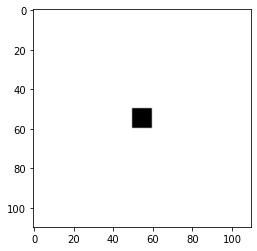

2.9532631620129157
optimum sigma:  1
magnitude of optimum mag:  2.2576957931910724


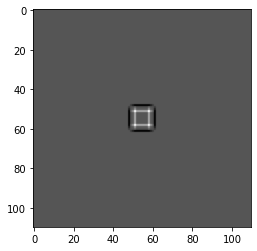

In [218]:
#create sample
square = np.zeros((10,10))
square = np.pad(square,(50, 50), 'constant', constant_values=1)

plt.imshow(square, cmap="gray")
plt.show()

# print sample
blur = cv2.GaussianBlur(square,(3,3), 3)
laplacian = cv2.Laplacian(blur, cv2.CV_64F)
plt.imshow(laplacian, 'gray')
mag = np.linalg.norm(laplacian)
print(mag)

# do experiment
opt = -np.inf
mag = -np.inf
for i in range(1,100):
    blur = cv2.GaussianBlur(square,(7,7),i)
    laplacian = cv2.Laplacian(blur, cv2.CV_64F)
    if mag < np.linalg.norm(laplacian):
        mag = np.linalg.norm(laplacian)
        opt = i
print("optimum sigma: ", opt)
print("magnitude of optimum mag: ", mag)

## part2: Implementation Task

#### 1.  Compute image gradient magnitudes and directions over the whole image, thresholdingsmall gradient magnitudes to zero.  You should empirically set a reasonable value for the threshold for each of the input images.

In [219]:
img = cv2.imread('./Q3/1.jpg', cv2.IMREAD_GRAYSCALE)
img = np.float32(img) / 255.0
print(img.shape)
def calc_grad_mag_dir(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=1)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=1)
    norm = np.sqrt(np.add(np.power(grad_x,2), np.power(grad_y,2)))
    angle = np.arctan2(grad_y, grad_x)
    angle = np.rad2deg(np.where(angle<0, angle + np.pi, angle))
    return norm, angle

norm,angle = calc_grad_mag_dir(img)


(286, 230)


#### 2. Center a cell grid (m × n) on the image. To create this grid cell, assume the grid cells are square and we have a fixed-size length for each of the cells in this grid; let us call that size τ . For example, if your image size is 1021 ×975 and τ = 8, then you will have a grid size of (m = 127) × (n = 121). You can ignore the boundary of the image that can not be fit into a grid (on either end), i. e., just consider the crop of the image that fits to the grid perfectly, which is 1016 × 968 in this example.

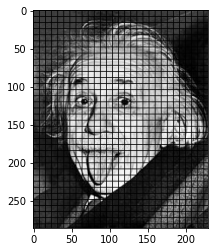

In [220]:
def create_grid_size(img, cell_size):
    m, n = np.shape(img)
    m = int(np.floor(m/cell_size))
    n = int(np.floor(n/cell_size))
    return m, n


def create_array_of_croped_image(img, cell_size):
    tiles = [img[x:x+cell_size,y:y+cell_size] for x in range(0,img.shape[0],cell_size) for y in range(0,img.shape[1],cell_size)]
    new_tiles = []
    for i in range(len(tiles)):
        if tiles[i].shape[0]!=cell_size or tiles[i].shape[1]!=cell_size:
            continue
        new_tiles.append(tiles[i])

    return new_tiles


def print_sample_cell_grid(img, cell_size):
    img2= img.copy()
    img2[:, ::cell_size] = [0]
    img2[::cell_size, :] = [0]
    plt.imshow(img2, cmap="gray")


m, n = create_grid_size(img, 8)
new_tiles = create_array_of_croped_image(img, 8)
print_sample_cell_grid(img, 8)

#### 3. For each cell, form an orientation histogram by quantizing the gradient directions and, for each such orientation bin, add the (thresholded) gradient magnitudes. This process can be done in two steps: Imagine gradient orientations are discretized by 6 bins:[−15◦, 15◦), [15◦, 45◦), [45◦, 75◦), [75◦, 105◦), [105◦, 135◦), [135◦, 165◦) Remember 165◦ is equivalent to −15◦ where the orientation is not directed. Now create a 3D array (m × n × 6) where in element (i, j, k) of this 3D array you will store the accumulated gradient magnitudes over all the pixels in the cell (i, j) with gradient orientations corresponding to bin k. Another approach for constructing the HOG, is to collect the number of occurrences in each bin, rather than accumulating the magnitudes of occurrences; i.e. in element (i, j, k) of the histogram, we store the number of pixels in cell (i, j) with gradient orientations corresponding to bin k Choose reasonable values for the threshold and cell size, and then visualize the resulting 3D arrays (using both approaches) on the given images similar to the quiver plot of Figure 1. Briefly, compare the two approaches by inspecting the visualizations.(15 marks) Hint: You can use any package/function for creating the visualization in Figure 1. One way to do that is to superimpose 6 quiver plots (one for each bin), generated by quiver function in matplotlib package. For the remaining tasks, you can use either approaches for constructing HOG. Make sure to explicitly mention your choice in the report.

In [221]:
def get_bin_from_angle(angle):
	if 0 <= angle < 15 or 165 <= angle < 180:
		return 0
	elif 15 <= angle < 45:
		return 1
	elif 45 <= angle < 75:
		return 2
	elif 75 <= angle < 105:
		return 3
	elif 105 <= angle < 135:
		return 4
	elif 135 <= angle < 165:
		return 5

def build_histogram(norm_img, angle_img, cell_size, bin_size=6):
	m, n = create_grid_size(norm_img, cell_size)
	histogram = np.zeros((m, n, bin_size))

	array_of_cropped_image_norm = create_array_of_croped_image(norm_img, cell_size)
	array_of_cropped_image_norm = np.array(array_of_cropped_image_norm)
	array_of_cropped_image_norm = array_of_cropped_image_norm.reshape(m,n, cell_size, cell_size)

	array_of_cropped_image_angle = create_array_of_croped_image(angle_img, cell_size)
	array_of_cropped_image_angle = np.array(array_of_cropped_image_angle)
	array_of_cropped_image_angle = array_of_cropped_image_angle.reshape(m,n, cell_size, cell_size)

	for i in range(0, m):
		for j in range(0, n):
			for x in range(cell_size):
				for y in range(cell_size):
					norm = array_of_cropped_image_norm[i,j,x,y]
					angle = array_of_cropped_image_angle[i,j,x,y]
					bin = get_bin_from_angle(angle)
					histogram[i][j][bin] += norm


	return histogram

def build_histogram2(norm_img, angle_img, cell_size, bin_size=6):
	m, n = create_grid_size(norm_img, cell_size)
	histogram = np.zeros((m, n, bin_size))

	array_of_cropped_image_norm = create_array_of_croped_image(norm_img, cell_size)
	array_of_cropped_image_norm = np.array(array_of_cropped_image_norm)
	array_of_cropped_image_norm = array_of_cropped_image_norm.reshape(m,n, cell_size, cell_size)

	array_of_cropped_image_angle = create_array_of_croped_image(angle_img, cell_size)
	array_of_cropped_image_angle = np.array(array_of_cropped_image_angle)
	array_of_cropped_image_angle = array_of_cropped_image_angle.reshape(m,n, cell_size, cell_size)

	for i in range(0, m):
		for j in range(0, n):
			for x in range(cell_size):
				for y in range(cell_size):
					norm = array_of_cropped_image_norm[i,j,x,y]
					angle = array_of_cropped_image_angle[i,j,x,y]
					bin = get_bin_from_angle(angle)
					num_pixels = len(np.where(norm>0))
					histogram[i][j][bin] += num_pixels


	return histogram

In [222]:
def visualize_hog(img, hog, cell_size, block_size, num_bins=6, max_len = 10):
    num_cell_h, num_cell_w = create_grid_size(img, 8) 
    if block_size!=0:
        num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
        histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
        histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  
        angles = np.arange(0, np.pi, np.pi/num_bins)
        mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
        mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins)) 
        mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  
        
    else:
        histogram = hog.reshape((num_cell_h, num_cell_w, num_bins))
        angles = np.arange(0, np.pi, np.pi/num_bins)
        mesh_x, mesh_y = np.meshgrid(np.r_[0: cell_size*num_cell_w: cell_size], np.r_[0: cell_size*num_cell_h: cell_size])
        mesh_u = histogram * np.sin(angles).reshape((1, 1, num_bins)) 
        mesh_v = histogram * -np.cos(angles).reshape((1, 1, num_bins))  
        
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                color='red', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    plt.show()

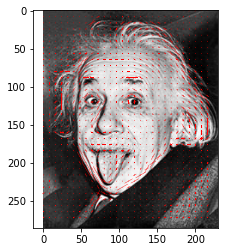

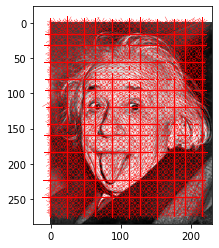

In [223]:
norm, angle = calc_grad_mag_dir(img)
histogram1 = build_histogram(norm, angle, 8)


histogram2 = build_histogram2(norm, angle, 8)

visualize_hog(img, histogram1, 8, 0)
visualize_hog(img, histogram2, 8, 0)
plt.show()


From the example the second approach of storing the number of pixels in the cell with gradient oridentation corresponding to bin k were more sensitive to local changes

In [224]:
def histogram_normalization(block, block_size):
    e = 0.001       
    x,y,z = np.shape(block)
    return_block = np.zeros(x * y * z).reshape(np.shape(block))
    for i in range (0, block_size):
        for j in range (0, block_size):
            division = np.sqrt(np.sum(block[i,j,:] ** 2) + e ** 2)
            return_block[i,j,:] = block[i,j,:]/division
    return return_block.reshape(x*y*z)


def get_block_descriptor(histogram, block_size):
    m, n, _ = np.shape(histogram)
    n_M = m - (block_size - 1)
    n_N = n - (block_size - 1)
    n_block = 6 * (block_size ** 2)
    histogram_normalized = np.zeros((n_M, n_N, n_block))

    for i in range (0, n_M):
        for j in range (0, n_N):
            block_ = histogram[i:i+block_size, j:j+block_size, :]
            histogram_normalized[i, j, :] = histogram_normalization(block_, block_size)
    return histogram_normalized
    
    

The resulting new histogram array will have the size of (m − 1) × (n − 1) × 24. Compute
normalized histogram arrays for the provided images, and store them in a single line text file
where the data is stored row by row (first row then second row etc.). Submit both your code
and the files that are generated by your code. Please note that the file should have the same
name as the image (e.g. ‘image.jpg’ → ‘image.txt’). (15 marks)

In [225]:
norm, angle = calc_grad_mag_dir(img)
histogram = build_histogram(norm, angle, 8)
hog = get_block_descriptor(histogram, 2)

with open('1.txt', 'w') as f:
    f.write('# Array shape: {0}\n'.format(hog.shape))
    for count, slice in enumerate(hog):
        np.savetxt(f, slice)
        f.write('# {0} slice\n'.format(count))

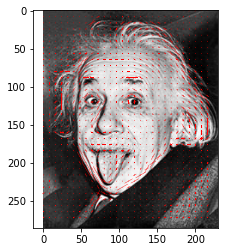

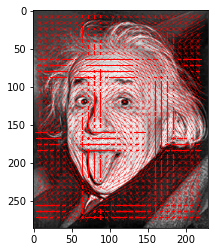

In [226]:
hog = get_block_descriptor(histogram, 2)
hog1 = visualize_hog(img, histogram, 8, 0)
hog3 = visualize_hog(img, hog, 8, 2)
plt.show()

In addition to the provided images, use your own camera (e.g. smartphone camera) to
capture two images of the same scene, one with flash and one without flash. Convert the
images to gray-scale, and down-sample the images if needed to avoid excessive computation
overhead.


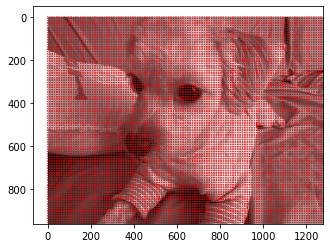

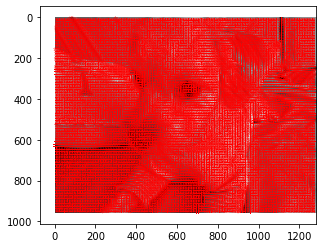

In [229]:
img2 = cv2.imread('./Q3_self/1.jpg', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('./Q3_self/2.jpg', cv2.IMREAD_GRAYSCALE)
img2 = np.float32(img2) / 255.0
img3 = np.float32(img3) / 255.0

norm2, angle2 = calc_grad_mag_dir(img2)
histogram2 = build_histogram(norm2, angle2, 8)
hog2 = get_block_descriptor(histogram2, 2)

visualize_hog(img2, histogram2, 8, 0)
visualize_hog(img2, hog2, 8, 2)
plt.show()

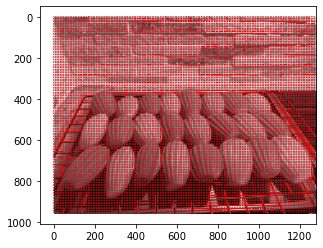

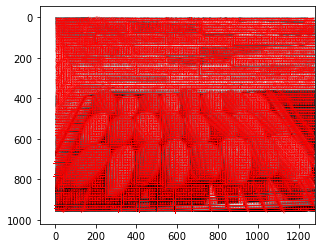

In [228]:
norm3, angle3 = calc_grad_mag_dir(img3)
histogram3 = build_histogram(norm3, angle3, 8)
hog3 = get_block_descriptor(histogram3, 2)
visualize_hog(img3, histogram3, 8, 0)
visualize_hog(img3, hog3, 8, 2)
plt.show()

Third, by comparing the results, argue why or why not the normalization of HOG maybe beneficial.  Limit your discussion to a paragraph,  containing the main points.  You cancompare the histograms visually or you may want to define a quantifiable measure to comparethe  histograms  for  pair  of  with-flash/no-flash  images.   If  you  choose  to  visually  compare,provide the details of your visualization approach for normalized HOG; alternatively, if youdecide  to  quantitatively  compare  the  histograms,  include  the  function  you  used  and  yourjustification in the report.(20 marks)

The normalization of HOG was performed by accumlating a measure of local histogram's energy over local groups of cell we defined as blocks. As shown from the results presented from the examples above(also in results folder), the normalized HOG has performed better invariance to shadowing, and illumination, and edge contrast. In other word, normalized HOG removed the effects of the local differences in the image.